# Auto_Colorizer

### Import Libraries

In [1]:
import os
import shutil
import time
import splitfolders
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torchviz import make_dot
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io
from skimage.color import rgb2gray, rgb2lab, lab2rgb

### Split the Data

In [2]:
#splitfolders.ratio(r'C:\Users\howle\OneDrive\Documents\indoorCVPR_09\Images', output=r"C:\Users\howle\OneDrive\Documents\indoor_scenes_data",seed=123,ratio=(.8, 0.1,0.1))

#splitfolders.ratio(r'Source folder of dataset', output=r"Destination folder for data splits",seed=123,ratio=(.8, 0.1,0.1))

### Check out a Sample Image

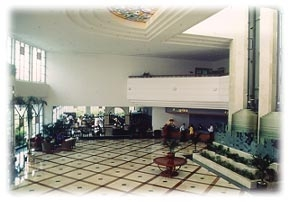

In [3]:
from IPython.display import Image, display
display(Image(filename=r'C:\Users\howle\OneDrive\Documents\indoor_scenes_data\train\train_images\airport_inside_0003.jpg'))

### Clear the Cache

In [4]:
torch.cuda.empty_cache()

### Model Architecture

In [5]:
class Auto_Colorizer(nn.Module):
    
    '''The decoder is a series of convolutional layers with upsampling.
        
        Model accepts the Lightness channel from LAB iamges.
        
        Generatates A&B color channels in the LAB colorspace'''
        
    def __init__(self):
        
        '''Encoder'''
        
        super(Auto_Colorizer, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 7, stride=2, padding = 3),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(64,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size = 3, stride=1, padding = 1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(128,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128)
            
        )
        
        '''Decoder, convolutions with upsampling'''

        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, input):

        features = self.encoder(input)
        #print(features.shape)
        out = self.decoder(features)
        return out

### Viewing the model Architecture

In [6]:
model = Auto_Colorizer()
model

Auto_Colorizer(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    

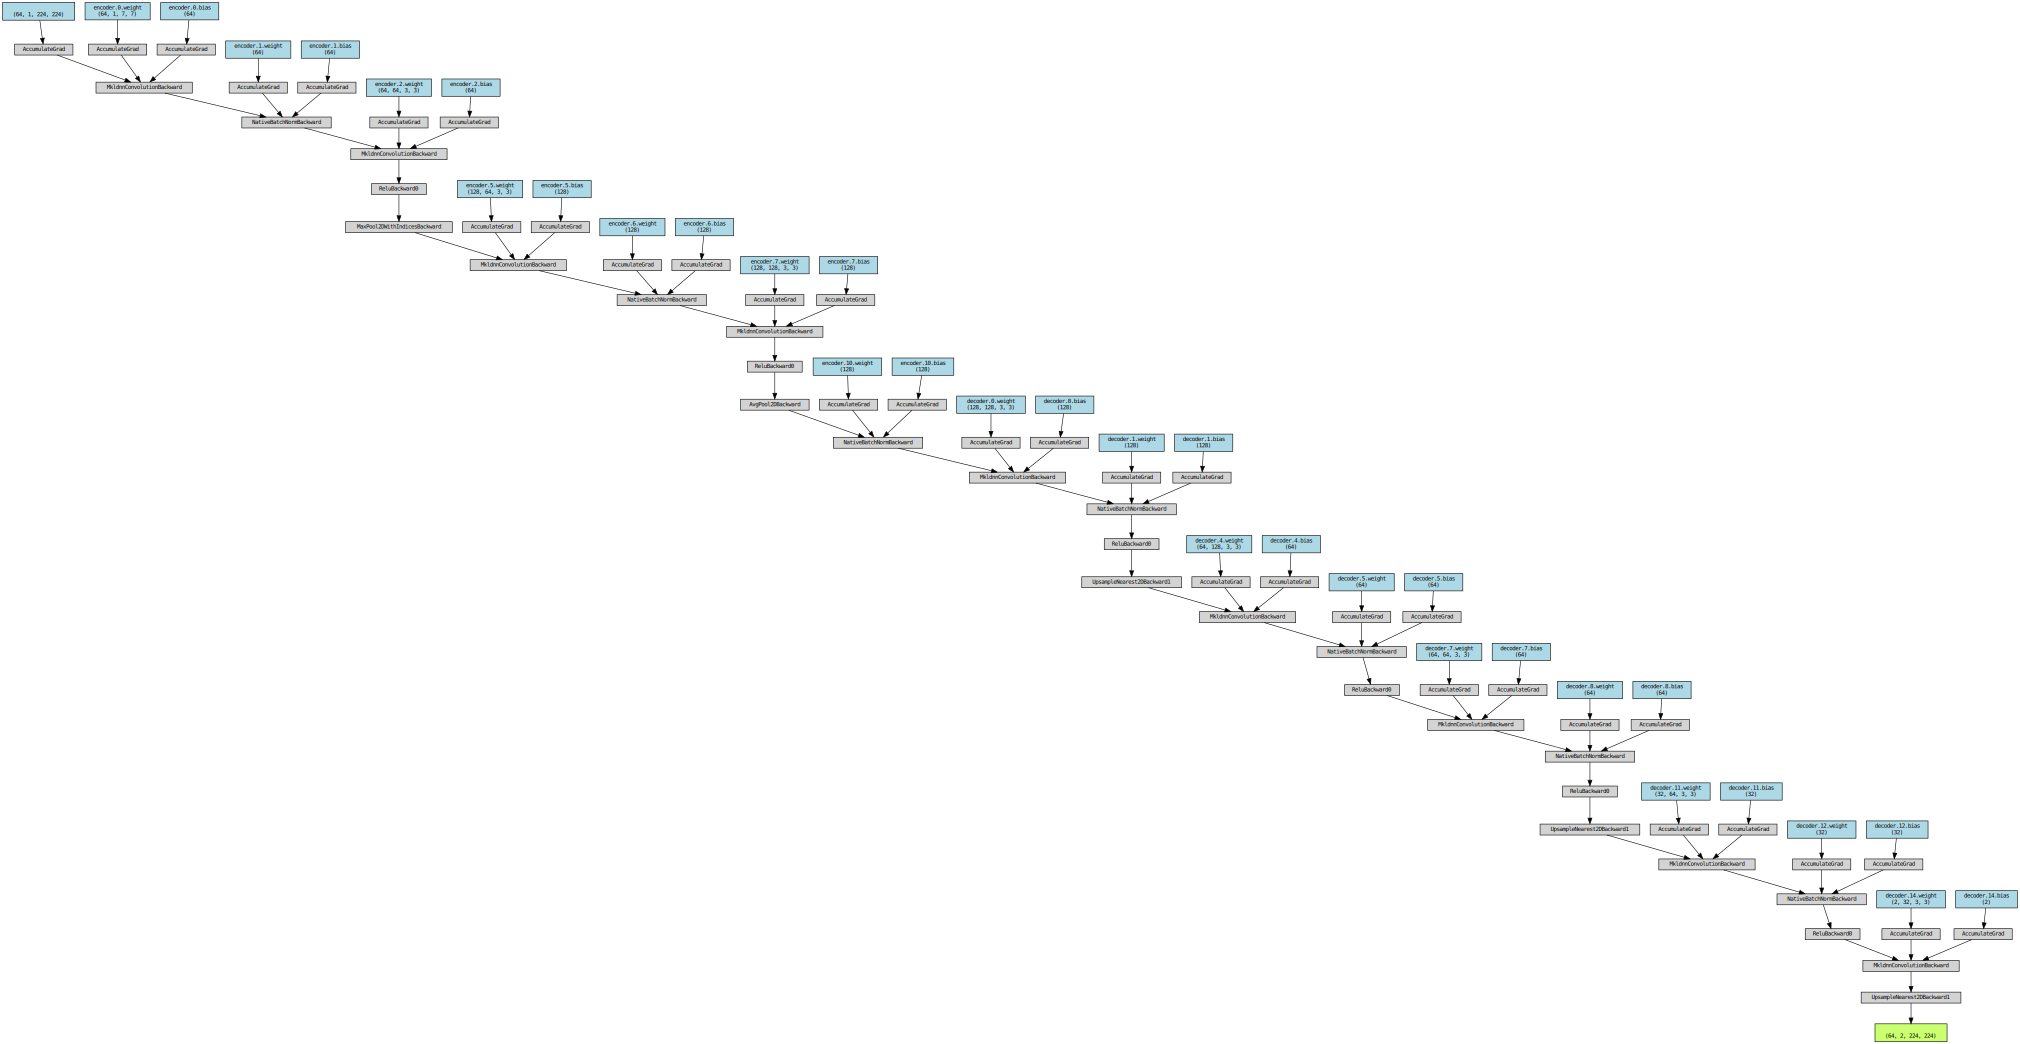

In [7]:
x = torch.zeros([64, 1, 224, 224], dtype=torch.float, requires_grad=True)
out = model(x)
dot = make_dot(out, params=dict(model.named_parameters()))
dot

In [8]:
def resize_graph(dot, size_per_element=0.15, min_size=12):
    """Resize the graph according to how much content it contains.
    Modify the graph in place.
    """
    # Get the approximate number of nodes and edges
    num_rows = len(dot.body)
    content_size = num_rows * size_per_element
    size = max(min_size, content_size)
    size_str = str(size) + "," + str(size)
    dot.graph_attr.update(size=size_str)


resize_graph(dot,size_per_element=1,min_size=20)
#dot.render("model_graph",format="png")

In [9]:
model = model.cuda()

### Some Hyperparameters

In [10]:
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
best_losses = 10000000000
epochs = 20

### Helper Functions

#### Grayscale Image Conversion

In [11]:
class GrayscaleImageFolder(datasets.ImageFolder):
    '''Image folder, which converts images to grayscale.
        
        Outputs original image, A&B channels and the target'''

    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
            img_lab = rgb2lab(img_original)
            img_lab = (img_lab + 128) / 255
            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
            img_original = rgb2gray(img_original)
            img_original = torch.from_numpy(img_original).unsqueeze(0).float()
            
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img_original, img_ab, target

#### Dataloaders

In [12]:
# Training Dataloader, Shuffled
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder(r'C:\Users\howle\OneDrive\Documents\indoor_scenes_data\train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation Dataloader, Shuffled
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder(r'C:\Users\howle\OneDrive\Documents\indoor_scenes_data\val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=True)

# Test Dataloader, Not Shuffled
test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
test_imagefolder = GrayscaleImageFolder(r'C:\Users\howle\OneDrive\Documents\indoor_scenes_data\test' , test_transforms)
test_loader = torch.utils.data.DataLoader(test_imagefolder, batch_size=64, shuffle=False)

#### Pytorch Average Meter Loss Calculator

In [13]:
class AverageMeter(object):
    
    '''Class for calculating losses'''
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
def to_rgb(grayscale_input, ab_input, save_path, save_name):
    
    '''Takes in the grayscale and a&b channels,
        converts to RGB, 3-channel image,
        saves images to specified folder
        
        This allows us to view the results of the colorization by the model'''
    
    plt.clf()
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy()
    color_image = color_image.transpose((1, 2, 0))
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [15]:
def validate(val_loader, model, criterion, save_images, epoch):
    model.eval()

    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    already_saved_images = False
    for i, (input_gray, input_ab, target) in enumerate(val_loader):
        data_time.update(time.time() - end)
        input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()
        output_ab = model(input_gray)
        loss = criterion(output_ab, input_ab)
        losses.update(loss.item(), input_gray.size(0))

        if save_images and not already_saved_images:
            already_saved_images = True
            for j in range(min(len(output_ab), 10)):
                save_path = {'grayscale': r"C:\Users\howle\OneDrive\Documents\indoor_scenes_data\outputs\gray", 'colorized': r"C:\Users\howle\OneDrive\Documents\indoor_scenes_data\outputs\color"}
                save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
                to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)
                
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 25 == 0:
            print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
            i, len(val_loader), batch_time=batch_time, loss=losses))

    print(f'Validation loss: {losses.avg}')
    return losses.avg

In [16]:
def train(train_loader, model, criterion, optimizer, epoch):
    
    print('Starting training epoch {}'.format(epoch))
    model.train()
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()
    end = time.time()
    
    for i, (input_gray, input_ab, target) in enumerate(train_loader):
        input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()
        data_time.update(time.time() - end)
        output_ab = model(input_gray) 
        loss = criterion(output_ab, input_ab) 
        losses.update(loss.item(), input_gray.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_time.update(time.time() - end)
        end = time.time()

        if (i % 25 == 0) or (i == 194):
            print('Epoch: [{0}][{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses))

    print('Epoch {} complete.'.format(epoch))

In [17]:
os.makedirs(r'C:\Users\howle\OneDrive\Documents\indoor_scenes_data\outputs\color', exist_ok=True)
os.makedirs(r'C:\Users\howle\OneDrive\Documents\indoor_scenes_data\outputs\gray', exist_ok=True)
os.makedirs(r'C:\Users\howle\OneDrive\Documents\indoor_scenes_data\checkpoints', exist_ok=True)
save_images = True

In [18]:
for epoch in range(epochs):
    train(train_loader, model, criterion, optimizer, epoch)
    
    with torch.no_grad():
        losses = validate(val_loader, model, criterion, save_images, epoch)
        
    if losses < best_losses:
        best_losses = losses
        torch.save(model.state_dict(), 'C:/Users/howle/OneDrive/Documents/indoor_scenes_data/checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
Epoch: [0][0/194]	Time 2.316 (2.316)	Data 1.470 (1.470)	Loss 0.8446 (0.8446)	
Epoch: [0][25/194]	Time 1.446 (1.486)	Data 1.405 (1.414)	Loss 0.2238 (0.4335)	
Epoch: [0][50/194]	Time 1.320 (1.467)	Data 1.280 (1.410)	Loss 0.0813 (0.2852)	
Epoch: [0][75/194]	Time 1.587 (1.465)	Data 1.547 (1.413)	Loss 0.0358 (0.2088)	
Epoch: [0][100/194]	Time 1.491 (1.460)	Data 1.450 (1.411)	Loss 0.0184 (0.1630)	
Epoch: [0][125/194]	Time 1.465 (1.464)	Data 1.423 (1.416)	Loss 0.0079 (0.1329)	
Epoch: [0][150/194]	Time 1.326 (1.464)	Data 1.286 (1.418)	Loss 0.0075 (0.1121)	
Epoch: [0][175/194]	Time 1.683 (1.464)	Data 1.642 (1.418)	Loss 0.0045 (0.0970)	
Epoch 0 complete.


C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 67 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 52 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 13 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/24]	Time 1.658 (1.658)	Loss 0.0049 (0.0049)	
Validation loss: 0.00534686362639382
Starting training epoch 1
Epoch: [1][0/194]	Time 1.482 (1.482)	Data 1.437 (1.437)	Loss 0.0053 (0.0053)	
Epoch: [1][25/194]	Time 1.495 (1.444)	Data 1.452 (1.403)	Loss 0.0057 (0.0049)	
Epoch: [1][50/194]	Time 1.364 (1.438)	Data 1.323 (1.397)	Loss 0.0053 (0.0047)	
Epoch: [1][75/194]	Time 1.330 (1.440)	Data 1.289 (1.399)	Loss 0.0040 (0.0047)	
Epoch: [1][100/194]	Time 1.327 (1.442)	Data 1.286 (1.401)	Loss 0.0043 (0.0046)	
Epoch: [1][125/194]	Time 1.440 (1.447)	Data 1.399 (1.406)	Loss 0.0043 (0.0045)	
Epoch: [1][150/194]	Time 1.433 (1.449)	Data 1.391 (1.408)	Loss 0.0044 (0.0045)	
Epoch: [1][175/194]	Time 1.431 (1.446)	Data 1.389 (1.405)	Loss 0.0033 (0.0044)	
Epoch 1 complete.


C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 496 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 41 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/24]	Time 1.619 (1.619)	Loss 0.0043 (0.0043)	
Validation loss: 0.004149524523689854
Starting training epoch 2
Epoch: [2][0/194]	Time 1.554 (1.554)	Data 1.509 (1.509)	Loss 0.0042 (0.0042)	
Epoch: [2][25/194]	Time 1.428 (1.402)	Data 1.386 (1.361)	Loss 0.0038 (0.0040)	
Epoch: [2][50/194]	Time 1.289 (1.407)	Data 1.248 (1.366)	Loss 0.0036 (0.0040)	
Epoch: [2][75/194]	Time 1.445 (1.416)	Data 1.404 (1.375)	Loss 0.0038 (0.0039)	
Epoch: [2][100/194]	Time 1.353 (1.426)	Data 1.312 (1.385)	Loss 0.0035 (0.0039)	
Epoch: [2][125/194]	Time 1.477 (1.436)	Data 1.436 (1.395)	Loss 0.0035 (0.0038)	
Epoch: [2][150/194]	Time 1.431 (1.433)	Data 1.390 (1.392)	Loss 0.0041 (0.0038)	
Epoch: [2][175/194]	Time 1.332 (1.440)	Data 1.291 (1.399)	Loss 0.0035 (0.0038)	
Epoch 2 complete.


C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 218 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/24]	Time 1.695 (1.695)	Loss 0.0034 (0.0034)	
Validation loss: 0.0036123650750269818
Starting training epoch 3
Epoch: [3][0/194]	Time 1.330 (1.330)	Data 1.286 (1.286)	Loss 0.0034 (0.0034)	
Epoch: [3][25/194]	Time 1.417 (1.439)	Data 1.374 (1.398)	Loss 0.0034 (0.0036)	
Epoch: [3][50/194]	Time 1.370 (1.457)	Data 1.329 (1.416)	Loss 0.0032 (0.0036)	
Epoch: [3][75/194]	Time 1.465 (1.449)	Data 1.424 (1.408)	Loss 0.0035 (0.0036)	
Epoch: [3][100/194]	Time 1.317 (1.452)	Data 1.276 (1.410)	Loss 0.0033 (0.0036)	
Epoch: [3][125/194]	Time 1.543 (1.454)	Data 1.501 (1.412)	Loss 0.0033 (0.0036)	
Epoch: [3][150/194]	Time 1.406 (1.451)	Data 1.365 (1.410)	Loss 0.0037 (0.0036)	
Epoch: [3][175/194]	Time 1.303 (1.448)	Data 1.262 (1.407)	Loss 0.0029 (0.0036)	
Epoch 3 complete.


C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 86 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/24]	Time 1.584 (1.584)	Loss 0.0032 (0.0032)	
Validation loss: 0.0036554858341769146
Starting training epoch 4
Epoch: [4][0/194]	Time 1.589 (1.589)	Data 1.544 (1.544)	Loss 0.0031 (0.0031)	
Epoch: [4][25/194]	Time 1.465 (1.461)	Data 1.424 (1.420)	Loss 0.0028 (0.0033)	
Epoch: [4][50/194]	Time 1.431 (1.461)	Data 1.389 (1.419)	Loss 0.0042 (0.0035)	
Epoch: [4][75/194]	Time 1.475 (1.456)	Data 1.434 (1.414)	Loss 0.0033 (0.0035)	
Epoch: [4][100/194]	Time 1.488 (1.459)	Data 1.446 (1.418)	Loss 0.0038 (0.0035)	
Epoch: [4][125/194]	Time 1.468 (1.454)	Data 1.427 (1.412)	Loss 0.0036 (0.0035)	
Epoch: [4][150/194]	Time 1.387 (1.452)	Data 1.346 (1.410)	Loss 0.0042 (0.0035)	
Epoch: [4][175/194]	Time 1.430 (1.450)	Data 1.390 (1.409)	Loss 0.0042 (0.0035)	
Epoch 4 complete.


C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 10 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/24]	Time 1.699 (1.699)	Loss 0.0040 (0.0040)	
Validation loss: 0.0033445995387060964
Starting training epoch 5
Epoch: [5][0/194]	Time 1.322 (1.322)	Data 1.277 (1.277)	Loss 0.0033 (0.0033)	
Epoch: [5][25/194]	Time 1.355 (1.436)	Data 1.313 (1.395)	Loss 0.0041 (0.0033)	
Epoch: [5][50/194]	Time 1.404 (1.426)	Data 1.363 (1.385)	Loss 0.0027 (0.0033)	
Epoch: [5][75/194]	Time 1.507 (1.437)	Data 1.466 (1.396)	Loss 0.0031 (0.0034)	
Epoch: [5][100/194]	Time 1.366 (1.436)	Data 1.325 (1.395)	Loss 0.0032 (0.0034)	
Epoch: [5][125/194]	Time 1.367 (1.442)	Data 1.326 (1.401)	Loss 0.0031 (0.0034)	
Epoch: [5][150/194]	Time 1.275 (1.442)	Data 1.234 (1.401)	Loss 0.0031 (0.0034)	
Epoch: [5][175/194]	Time 1.493 (1.437)	Data 1.452 (1.396)	Loss 0.0032 (0.0034)	
Epoch 5 complete.


C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 94 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/24]	Time 1.613 (1.613)	Loss 0.0034 (0.0034)	
Validation loss: 0.0034523558901161503
Starting training epoch 6
Epoch: [6][0/194]	Time 1.694 (1.694)	Data 1.650 (1.650)	Loss 0.0036 (0.0036)	
Epoch: [6][25/194]	Time 1.492 (1.451)	Data 1.450 (1.410)	Loss 0.0039 (0.0034)	
Epoch: [6][50/194]	Time 1.377 (1.430)	Data 1.336 (1.389)	Loss 0.0033 (0.0034)	
Epoch: [6][75/194]	Time 1.446 (1.440)	Data 1.404 (1.399)	Loss 0.0034 (0.0034)	
Epoch: [6][100/194]	Time 1.392 (1.435)	Data 1.352 (1.394)	Loss 0.0034 (0.0033)	
Epoch: [6][125/194]	Time 1.394 (1.433)	Data 1.353 (1.392)	Loss 0.0029 (0.0033)	
Epoch: [6][150/194]	Time 1.526 (1.432)	Data 1.485 (1.391)	Loss 0.0032 (0.0033)	
Epoch: [6][175/194]	Time 1.669 (1.433)	Data 1.627 (1.392)	Loss 0.0032 (0.0033)	
Epoch 6 complete.
Validate: [0/24]	Time 1.528 (1.528)	Loss 0.0030 (0.0030)	
Validation loss: 0.003243544474024409
Starting training epoch 7
Epoch: [7][0/194]	Time 1.450 (1.450)	Data 1.405 (1.405)	Loss 0.0035 (0.0035)	
Epoch: [7][25/194]	Time 

C:\Users\howle\anaconda3\lib\site-packages\skimage\color\colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 14 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/24]	Time 1.605 (1.605)	Loss 0.0031 (0.0031)	
Validation loss: 0.0033104021357296723
Starting training epoch 15
Epoch: [15][0/194]	Time 1.522 (1.522)	Data 1.477 (1.477)	Loss 0.0028 (0.0028)	
Epoch: [15][25/194]	Time 1.493 (1.454)	Data 1.451 (1.412)	Loss 0.0026 (0.0033)	
Epoch: [15][50/194]	Time 1.427 (1.521)	Data 1.386 (1.479)	Loss 0.0030 (0.0032)	
Epoch: [15][75/194]	Time 1.488 (1.519)	Data 1.446 (1.477)	Loss 0.0027 (0.0032)	
Epoch: [15][100/194]	Time 1.526 (1.516)	Data 1.484 (1.474)	Loss 0.0029 (0.0032)	
Epoch: [15][125/194]	Time 1.423 (1.517)	Data 1.380 (1.475)	Loss 0.0053 (0.0032)	
Epoch: [15][150/194]	Time 1.523 (1.520)	Data 1.482 (1.479)	Loss 0.0034 (0.0032)	
Epoch: [15][175/194]	Time 1.464 (1.527)	Data 1.423 (1.485)	Loss 0.0034 (0.0032)	
Epoch 15 complete.
Validate: [0/24]	Time 1.592 (1.592)	Loss 0.0032 (0.0032)	
Validation loss: 0.0031588226053277874
Starting training epoch 16
Epoch: [16][0/194]	Time 1.311 (1.311)	Data 1.267 (1.267)	Loss 0.0036 (0.0036)	
Epoch: [16]

<Figure size 432x288 with 0 Axes>

In [19]:
#model.state_dict()

In [20]:
# sample_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
# sample_imagefolder = GrayscaleImageFolder(r'C:\Users\howle\OneDrive\Documents\indoor_scenes_data\single_sample' , sample_transforms)
# sample_loader = torch.utils.data.DataLoader(sample_imagefolder, batch_size=64, shuffle=False)

In [24]:
pretrained = torch.load(r"C:\Users\howle\OneDrive\Documents\indoor_scenes_data\checkpoints\model-epoch-20-losses-0.003.pth", map_location=lambda storage, loc: storage)
model.load_state_dict(pretrained)

# Colorizing and evaluating on test data using the final model
save_images = True
with torch.no_grad():
    validate(test_loader, model, criterion, save_images, 0)

Validate: [0/26]	Time 1.911 (1.911)	Loss 0.0031 (0.0031)	
Validate: [25/26]	Time 0.469 (1.543)	Loss 0.0033 (0.0031)	
Validation loss: 0.0031478452304555438


<Figure size 432x288 with 0 Axes>

In [22]:
!wget https://www.dropbox.com/s/kz76e7gv2ivmu8p/model-epoch-93.pth

'wget' is not recognized as an internal or external command,
operable program or batch file.
